# Age Detection with Convolutional Neural Network - Pre-Processing

# Importing Needed Libraries

In [ ]:
# For data preprocessing
import numpy as np
import pandas as pd
import random
from collections import Counter

# For img preprocessing
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# For files management
import os
import zipfile
from zipfile import ZipFile

# Google Colab API
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Determining Age Group

In [ ]:
# A function which maps "age" to "group age"
def determine_age_group(age):
        if age < 4:
            return 0 # 0-3
        elif age < 13:
            return 1 # 4-12
        elif age < 22:
            return 2 # 13-21
        elif age < 36:
            return 3 # 22-35
        elif age < 51:
            return 4 # 36-50
        elif age < 70: 
            return 5 # 51-69
        else:
            return 6 # 70+

# Unzpid UTKFace & Facial Age

In [ ]:
def ex_zip(zip_file_path, extracted_folder_path):
    # Define the path to the ZIP file containing the images
    with ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract the images to the specified folder
        zip_ref.extractall(extracted_folder_path)

In [ ]:
# Export 'UTKFace' & 'Facial Age' datasets
ex_zip("/content/drive/MyDrive/data/UTKFace.zip", "/content/dataset")
ex_zip("/content/drive/MyDrive/data/face_age.zip", "/content/dataset")

# Preprocessing images before entering model

In [ ]:
# Load and preprocess the images
def preprocess_images(limit_samples_per_group, folder_path=None, folder_path2=None, img_shape=200, gray_scale=True):

    # One of UTKFace\Facial Age must be included at function calling
    if folder_path is None and folder_path2 is None:
        raise ValueError("No data to load.")

    images = []
    labels = []
    group_counts = [0] * 7

    # For self checking and visualization
    utk_face_samples = [0] * 7
    facial_age_samples = [0] * 7

    # UTKFace insertation (optional)
    if folder_path is not None:
        for filename in os.listdir(folder_path):
            age = int(filename.split("_")[0])
            age_group = determine_age_group(age)  # Determine age group
            # print(f"Filename: {filename}, Age: {age}, Age Group: {age_group}")  # Self check
            img_path = os.path.join(folder_path,filename)
            # Read and resize the image
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (img_shape, img_shape))
            if gray_scale is True:
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) # (200, 200, 1)
            else:
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) # (200, 200, 3)
            # Check if the number of samples for the current age group has reached the limit
            if group_counts[age_group] <= limit_samples_per_group:
                images.append(img_resized)
                labels.append(age_group)
                group_counts[age_group] += 1
                utk_face_samples[age_group] += 1

    # Facial Age insertation (optional)
    if folder_path2 is not None:
        for folder in os.listdir(folder_path2):
            age_group = determine_age_group(int(folder))  # Determine age group
            for filename in os.listdir(os.path.join(folder_path2, folder)):
                    img_path = os.path.join(folder_path2, folder, filename)
                    # print(f"Filename: {filename}, Age: {int(folder)}, Age Group: {age_group}")  # Self check
                    img = cv2.imread(img_path)
                    img_resized = cv2.resize(img, (img_shape, img_shape))
                    if gray_scale is True:
                        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) # (200, 200, 1)
                    else:
                        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) # (200, 200, 3)
                    # Check if the number of samples for the current age group has reached the limit
                    if group_counts[age_group] <= limit_samples_per_group:
                        images.append(img_resized)
                        labels.append(age_group)
                        group_counts[age_group] += 1
                        facial_age_samples[age_group] += 1

    images = np.array(images)
    labels = np.array(labels)

    return images, labels , utk_face_samples, facial_age_samples

### Load the data from the corresponding folder

In [ ]:
# Define the folder paths containing the images
utkface_path = "/content/dataset/UTKFace"
facial_age_path = "/content/dataset/face_age"
max_sample = 10000

images, labels, utkface_age_counts, facial_age_counts = preprocess_images(facial_age_path,
                                                                           utkface_path, max_sample) # 200 X 200 shape, gray scale as default

### Show sample counts for each age group

In [ ]:


age_groups = {
    0: "0-3",
    1: "4-12",
    2: "13-21",
    3: "22-35",
    4: "36-50",
    5: "51-69",
    6: "70+"
}

age_counts = Counter(labels)

fig = px.bar(x=age_counts.keys(), y=age_counts.values(),
             title="Number of Images per Age Group",
             labels={"x": "Age Group", "y": "Number of Images"})

fig.update_xaxes(ticktext=[age_groups[i] for i in fig.data[0].x],
                  tickvals=fig.data[0].x)

fig.update_layout(font=dict(size=14))

fig.show()

### Show sample counts for each age group (+ data group affiliation)

In [ ]:

# Use 'age_groups' from previous block

fig = px.bar(x=age_groups.keys(), y=[utkface_age_counts, facial_age_counts],
             title="Number of Images per Age Group",
             labels={"x": "Age Group", "y": "Number of Images"},
             barmode='group')

fig.update_xaxes(ticktext=[age_groups[i] for i in fig.data[0].x],
                  tickvals=fig.data[0].x)

fig.update_layout(font=dict(size=14))

fig.show()

# Split images and labels into train, validation and test

In [ ]:
def split_data_by_age_group(images, labels, test_percent=0.2, validation_percent=0.2):
    # Create dicts to store indices for each age group
    age_group_indices = {i: [] for i in range(7)}

    # Populate age group indices dictionary
    for idx, label in enumerate(labels):
        age_group_indices[label].append(idx)

    x_train, y_train, x_test, y_test, x_validation, y_validation = [], [], [], [], [], []

    # Calculate the number of samples needed for testing and validation
    age_counts = [0] * 7
    for label in labels:
        age_counts[label] += 1
    total_samples = sum(age_counts)
    min_class_samples = min(age_counts)
    samples_per_group_test = int(min_class_samples * test_percent)
    min_class_samples = int(min_class_samples * (1-test_percent))
    samples_per_group_validation = int(min_class_samples * validation_percent)
    num_samples_train = total_samples - samples_per_group_test - samples_per_group_validation

    # Split data for each age group
    for age_group, indices in age_group_indices.items():
        # Shuffle indices
        np.random.shuffle(indices)

        # Take samples for testing and validation
        test_indices = indices[:samples_per_group_test]
        validation_indices = indices[samples_per_group_test:samples_per_group_test + samples_per_group_validation]

        # Append images and labels to respective lists
        x_test.extend(images[test_indices])
        y_test.extend(labels[test_indices])

        x_validation.extend(images[validation_indices])
        y_validation.extend(labels[validation_indices])

        # Update age_group_indices to exclude samples used for testing and validation
        age_group_indices[age_group] = indices[samples_per_group_test + samples_per_group_validation:]

    # Calculate the remaining samples for training from age groups
    remaining_train_indices = np.concatenate([indices for indices in age_group_indices.values()])
    np.random.shuffle(remaining_train_indices)
    train_indices = remaining_train_indices[:num_samples_train]

    # Append remaining samples for training
    x_train.extend(images[train_indices])
    y_train.extend(labels[train_indices])

    # Convert lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_validation, y_validation = np.array(x_validation), np.array(y_validation)

    return x_train, y_train, x_test, y_test, x_validation, y_validation

# Function usage
x_train, y_train, x_test, y_test, x_validation, y_validation = split_data_by_age_group(images, labels, test_percent=0.2, validation_percent=0.2)

# Print shapes to verify
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)
print("Validation data shape:", x_validation.shape)
print("Validation labels shape:", y_validation.shape)


### Avarege number of images per group

In [ ]:
num_train_images = x_train.shape[0]
print(f"avarge images per group : {(int)(num_train_images/7)}")
average=(int)(num_train_images/7)

In [ ]:
def plot_age_distribution(labels, title):
    age_counts = [0] * 7
    for label in labels:
        age_counts[label] += 1

    plt.bar(range(7), age_counts)
    plt.title(title)
    plt.xlabel("Age Group")
    plt.ylabel("Number of Samples")
    plt.show()

# Plot age distribution for each set
plot_age_distribution(y_train, "Age Distribution in Training Set")
plot_age_distribution(y_test, "Age Distribution in Test Set")
plot_age_distribution(y_validation, "Age Distribution in Validation Set")


# Augmantion of train pictures and addition to the train group


In [ ]:
num_train_images = x_train.shape[0]
average = 5000

# Define the augmentation techniques
augmentation_techniques = [
    iaa.Affine(rotate=(-45, 45)),  # random rotation between -45 and 45 degrees
    iaa.Fliplr(0.5),  # horizontal flip with 50% probability
]

# Define the augmentation sequence
seq = iaa.Sequential(augmentation_techniques)

x_train_balanced = []
y_train_balanced = []

for label, count in Counter(y_train).items():
    indices = np.where(y_train == label)[0]
    num_samples = len(indices)
    if num_samples > average:
        # Downsample the group
        downsampled_indices = np.random.choice(indices, size=int(average), replace=False)
        x_train_balanced.append(x_train[downsampled_indices])
        y_train_balanced.append(y_train[downsampled_indices])
    elif num_samples < average:
        # Augment the group until it reaches the average
        while num_samples < average:
            # Randomly select an augmentation technique for each image
            selected_augmentation = random.choice(augmentation_techniques)
            augmented_images = selected_augmentation.augment_images(x_train[indices])
            x_train_balanced.append(augmented_images)
            y_train_balanced.append(np.full(len(augmented_images), label))
            num_samples += len(augmented_images)

# Combine the original and balanced images
x_train = np.concatenate(x_train_balanced, axis=0)
y_train = np.concatenate(y_train_balanced, axis=0)

### Exampels for images get augmented

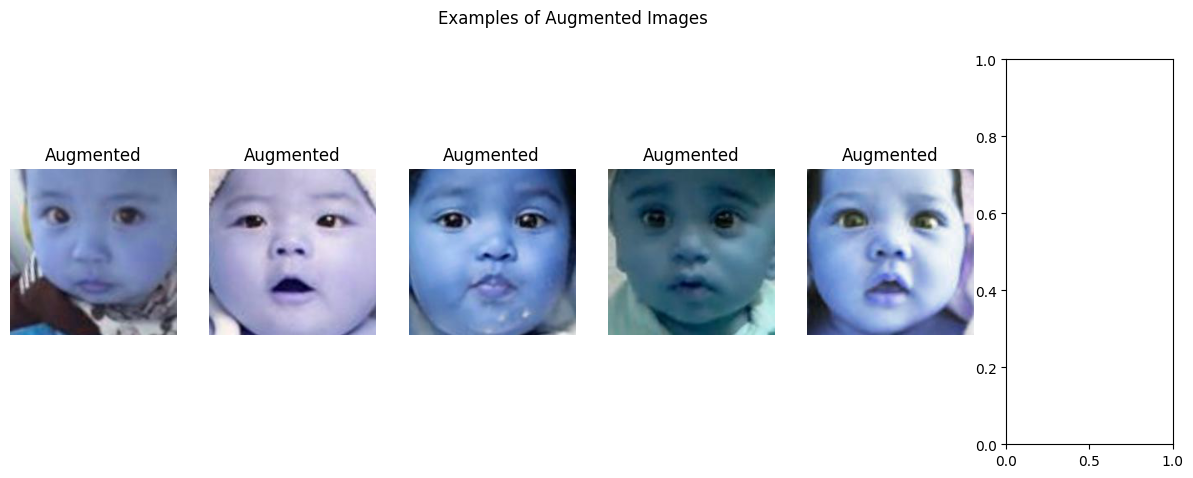

In [ ]:
# Select 5 random indices from the augmented images
random_indices = np.random.choice(np.where(y_train == 0)[0], size=5, replace=False)

# Plot the original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Original image
axes[0].imshow(x_train[random_indices[0]])
axes[0].set_title("Augmented")
axes[0].axis('off')

# Augmented images
for i, index in enumerate(random_indices[1:], start=1):
    axes[i].imshow(x_train[index])
    axes[i].set_title("Augmented")
    axes[i].axis('off')

plt.suptitle("Examples of Augmented Images")
plt.show()


## Age distribution groups on train

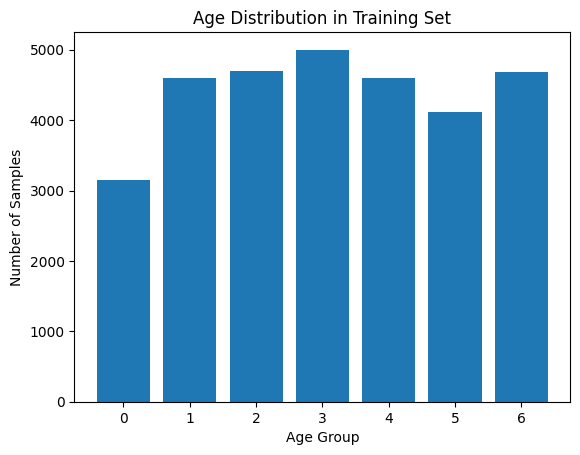

In [ ]:
def plot_age_distribution(labels):
    age_counts = [0] * 7
    for label in labels:
        age_counts[label] += 1

    plt.bar(range(7), age_counts)
    plt.title("Age Distribution in Training Set")
    plt.xlabel("Age Group")
    plt.ylabel("Number of Samples")
    plt.show()

plot_age_distribution(y_train)


# Create a directory to save the images


In [ ]:
train_zip_file = "/content/drive/MyDrive/data/TrainTest/Train/train_images_7000sampels_augmented&averageded.zip"
test_zip_file = "/content/drive/MyDrive/data/TrainTest/Test/test_images_7000sampels_augmented&averageded.zip"
validation_zip_file = "/content/drive/MyDrive/data/TrainTest/Validation/validation_images_7000sampels_augmented&averageded.zip"

In [ ]:
# Calculate the number of images for each age group in x_train
age_group_counts_train = Counter(y_train)

# Print the number of images for each age group
for age_group, count in age_group_counts_train.items():
    print(f"Age Group {age_group}: {count} images")



Age Group 4: 4600 images
Age Group 0: 3154 images
Age Group 5: 4119 images
Age Group 6: 4680 images
Age Group 3: 5000 images
Age Group 1: 4594 images
Age Group 2: 4704 images


# Save images to the directory and create from them zip files

In [ ]:
def create_zip_from_memory(images, labels, zip_filename):
    # Create a ZIP file for the images and labels
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for i, (image, label) in enumerate(zip(images, labels)):
            # Encode image as bytes
            image_bytes = cv2.imencode('.jpg', image)[1].tobytes()
            # Construct filename
            filename = f"image_{i}_label_{label}.jpg"
            # Write image bytes to the ZIP file
            zipf.writestr(filename, image_bytes)

    print(f"ZIP file created successfully: {zip_filename}")

# Create ZIP files


In [ ]:
# Save train images and create train ZIP file
create_zip_from_memory(x_train, y_train,train_zip_file)
# Save test images and create test ZIP file
create_zip_from_memory(x_test, y_test,test_zip_file)
# Save test images and create validation ZIP file
create_zip_from_memory(x_validation, y_validation,validation_zip_file)

print("ZIP files created successfully.")

ZIP file created successfully: /content/drive/MyDrive/data/TrainTest/Train/train_images_7000sampels_augmented&averageded.zip
ZIP file created successfully: /content/drive/MyDrive/data/TrainTest/Test/test_images_7000sampels_augmented&averageded.zip
ZIP file created successfully: /content/drive/MyDrive/data/TrainTest/Validation/validation_images_7000sampels_augmented&averageded.zip
ZIP files created successfully.
